## Holonomic RRT

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
import os
import shutil

In [61]:
class Node:
    def __init__(self, pose):
        self.pose = pose
        self.children = []
        self.parent = None
        self.params = []

In [62]:
class Env:
    def __init__(self, obstacles, xmin, xmax, ymin, ymax, zmin, zmax):
        self.obstacles = obstacles
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.zmin = zmin
        self.zmax = zmax
        
    def in_env(self, pose):
        x, y, z = pose
        if (x >= self.xmin) and (x <= self.xmax) and (y >= self.ymin) and (y <= self.ymax) and (z >= self.zmin) and (z <= self.zmax):
            return True
        return False
    
    def in_obst(self, pose, obst):
        x, y, z = pose
        if (x >= obst[0]) and (x <= obst[3]) and (y >= obst[1]) and (y <= obst[4]) and (z >= obst[2]) and (z <= obst[5]):
            return True
        return False
        
    def intersects_obst(self, pose1, pose2, obst):
        x1, y1, z1 = pose1
        x2, y2, z2 = pose2
        
        params = (x2 - x1, y2 - y1, z2 - z1)
        obst_size = (obst[3] - obst[0], obst[4] - obst[1], obst[5] - obst[2])
        
        n = np.int(np.max(np.abs(np.array(params)) / obst_size)) + 1
        
        for i in range(n+1):
            x, y, z = x1 + (x2 - x1) * i / n, y1 + (y2 - y1) * i / n, z1 + (z2 - z1) * i / n
            
            if self.in_obst((x, y, z), obst):
                return True
        
        return False
    
    def is_valid(self, pose1, pose2):
        for obst in self.obstacles:
            if self.intersects_obst(pose1, pose2, obst):
                return False
        return True

In [ ]:
class holonomic_RRT:
    def __init__(self, start_config, goal, env):
        self.psi = 0
        self.env = env
        self.goal = goal
        self.tree = Node(start_config)
        self.goal_reached = False
        self.goal_node = None
        self.goal_radius = 20

    def acceleration_command(self, theta, phi, T):
        """
        Derive ax,ay,az from theta,phi,T
        """
        c_theta, s_theta = np.cos(theta), np.sin(theta)
        c_phi, s_phi = np.cos(phi), np.sin(phi)
        c_psi, s_psi = np.cos(self.psi), np.sin(self.psi)
        acc_const = T
        
        ax = (- c_phi * s_theta * c_psi - s_phi * s_psi) * acc_const
        ay = (- c_phi * s_theta * s_psi - s_phi * c_psi) * acc_const
        az = -9.8 + (c_phi * c_theta) * acc_const
        
        return (ax, ay, az)
        
    def acceleration_control(self, a):
        """
        Convert accelerations to position
        """
        dx = a[0] / 2
        dy = a[1] / 2
        dz = a[2] / 2

        return dx, dy, dz
    
    def distance(self, pose1, pose2):
        return np.linalg.norm(np.array(pose1) - np.array(pose2))
        
    def get_closest_node(self, pose):
        node_queue = [self.tree]
        min_dist = 1000000
        min_node = None
        
        while (node_queue != []):
            cur_node = node_queue.pop(0)
            dist = self.distance(pose, cur_node.pose)
            
            if dist < min_dist:
                min_node = cur_node
                min_dist = dist
            
            node_queue.extend(cur_node.children)
            
        return min_node
            
    def plot_line(self, ax, pose1, pose2, color):
        ax.plot([pose1[0], pose2[0]], [pose1[1], pose2[1]], [pose1[2], pose2[2]], color=color, linewidth=1)
    
    def try_adding_goal(self):
        node = self.get_closest_node(self.goal)
        
        if self.distance(self.goal, node.pose) > self.goal_radius or not self.env.is_valid(self.goal, node.pose):
            return
        
        goal_node = Node(self.goal)
        goal_node.parent = node
        node.children.append(goal_node)
        self.goal_reached = True
        self.goal_node = goal_node
        
        
    def add_new_nodes(self, node, radius, max_num_nodes_at_same_time = 5, T_max = 50):
        nodes = []
        for i in range(max_num_nodes_at_same_time):
            theta = np.deg2rad(np.round(360 * np.random.rand(1)[0]))
            phi = np.deg2rad(np.round(360 * np.random.rand(1)[0]))
            T = T_max * np.random.rand(1)[0]
            
            pose = np.array(node.pose) + self.acceleration_control(self.acceleration_command(theta,phi,T))
            
            if (self.env.in_env(pose) and self.env.is_valid(pose, node.pose) and (radius == -1 or self.distance(pose, node.pose) <= radius)):
                new_node = Node(pose)
                new_node.parent = node
                new_node.params = [T, theta, phi]
                node.children.append(new_node)
                nodes.append(new_node)
                
        return nodes
        
    def showtree(self, ax, path, goal_check_iterations, radius,
                 max_num_nodes_at_same_time, T_max, rotate = False):
        """
        Create a new directory (say holonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        if os.path.isdir(path):
            shutil.rmtree(path)
            
        os.mkdir(path)
        
        env_dims = np.array([self.env.xmax - self.env.xmin, self.env.ymax - self.env.ymin, self.env.zmax - self.env.zmin])
        
        plt.savefig(f"{path}/snap0.png")
        count = 1
        
        while True:
            self.try_adding_goal()
            
            if self.goal_reached:
                self.plot_line(ax, self.goal_node.pose, self.goal_node.parent.pose, 'red')
                plt.savefig(f"{path}/snap{count}.png")
                break
                
            if rotate:
                ax.view_init(30, 10 * count)
                
            if (count-1) % goal_check_iterations == 0 and self.goal_reached == False:
                new_pose = self.goal
            else:
                new_pose = tuple(env_dims * np.random.rand(3) + np.array([self.env.xmin, self.env.ymin, self.env.zmin]))
                
            existing_node = self.get_closest_node(new_pose)
            new_nodes = self.add_new_nodes(existing_node, radius,  max_num_nodes_at_same_time, T_max)
            
            for new in new_nodes:
                self.plot_line(ax, new.pose, new.parent.pose, 'red')
                plt.savefig(f"{path}/snap{count}.png")
                count += 1
        # plt.show()
        
    def showpath(self, ax, path):
        """
        Create a new directory (say holonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        if not self.goal_reached:
            print("Not reached yet")
            return
        
        if os.path.isdir(path):
            shutil.rmtree(path)
            
        os.mkdir(path)
        
        final_path = []
        cur_node = self.goal_node
        
        while cur_node != None:
            final_path.append(cur_node)
            cur_node = cur_node.parent
            
        final_path.reverse()
        
        plt.savefig(f"{path}/snap0.png")
        count = 1
        for i in range(len(final_path) - 1):
            self.plot_line(ax, final_path[i].pose, final_path[i+1].pose, 'blue')
            plt.savefig(f"{path}/snap{count}.png")
            count += 1
            
        # plt.show()
        self.final_path = final_path   
        
    def cuboid_data(self, box):
        l = box[3] - box[0]
        w = box[4] - box[1]
        h = box[5] - box[2]
        x = [[0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0]]
        y = [[0, 0, w, w, 0],
             [0, 0, w, w, 0],
             [0, 0, 0, 0, 0],
             [w, w, w, w, w]]
        z = [[0, 0, 0, 0, 0],
             [h, h, h, h, h],
             [0, 0, h, h, 0],
             [0, 0, h, h, 0]]
        return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)

    def plot_final_params(self):
        T = []
        theta = []
        phi = []
        
        for node in self.final_path:
            if node.params:
                T.append(node.params[0])
                theta.append(node.params[1])
                phi.append(node.params[2])
                
        fig,axes = plt.subplots(3,1, figsize = (10,5))
        
        time = np.arange(len(T))
        axes[0].plot(time, T)
        axes[0].set_ylabel("Thrust")
        axes[0].set_xlabel("Time")
        
        axes[1].plot(time, theta)
        axes[1].set_ylabel("Theta")
        axes[1].set_xlabel("Time")
        
        axes[2].plot(time, phi)
        axes[2].set_ylabel("Phi")
        axes[2].set_xlabel("Time")
        
        plt.show()
        
    def show_env(self):
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        xs,ys,zs = self.tree.pose
        ax.scatter(xs,ys,zs)
        xg, yg, zg = self.goal
        ax.scatter(xg, yg, zg)
        
        for obst in self.env.obstacles:
            X, Y, Z = self.cuboid_data(obst)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2), zorder = 1)
        
        plt.show()
    
    def test_env(self, goal_check_iterations = 100, radius = -1, tree_dir = "holonomic/tree", path_dir = "holonomic/path", max_num_nodes_at_same_time = 3, T_max = 60):
        self.tree.children = []
        self.goal_reached = False
        self.goal_node = None
        
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        ax = Axes3D.Axes3D(fig)
        xs,ys,zs = self.tree.pose
        ax.scatter(xs,ys,zs)
        ax.scatter(xs,ys,zs)
        xg, yg, zg = self.goal
        ax.scatter(xg, yg, zg)
        ax.scatter(xg, yg, zg)
        
        for obst in self.env.obstacles:
            X, Y, Z = self.cuboid_data(obst)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2), zorder = 1)
        
        self.showtree(ax, tree_dir, goal_check_iterations, radius, max_num_nodes_at_same_time, T_max)
            
        self.showpath(ax, path_dir)
        plt.show()
        
        self.plot_final_params()

# Set 1

<ipython-input-63-470ff22a75b1>:214: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)


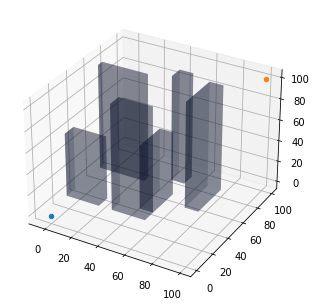

<ipython-input-63-470ff22a75b1>:232: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)
<ipython-input-63-470ff22a75b1>:233: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)


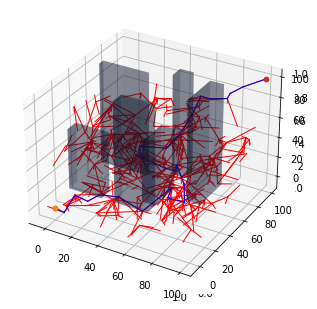

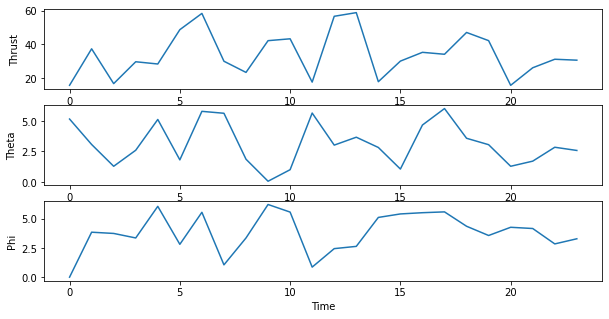

In [64]:
start = (0,0,0)
goal = (100,100,100)

# 3D boxes   lx, ly, lz, hx, hy, hz
obstacles= [[-5, 25, 0, 20, 35, 60],
            [30, 25, 0, 55, 35, 100],
            [45, 35, 0, 55, 60, 60],
            [45, 75, 0, 55, 85, 100],
            [-5, 65, 0, 30, 70, 100],
            [70, 50, 0, 80, 80, 100]]

env = Env(obstacles, -5, 100, -5, 100, -5, 100)

hn_RRT = holonomic_RRT(start, goal, env)
hn_RRT.show_env()
hn_RRT.test_env(goal_check_iterations = 20, radius = 30)

# Set 2

<ipython-input-63-470ff22a75b1>:214: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)


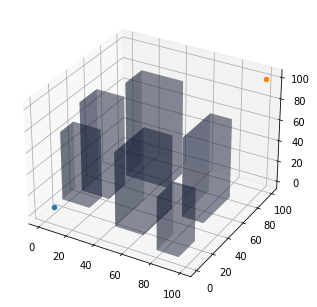

<ipython-input-63-470ff22a75b1>:232: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)
<ipython-input-63-470ff22a75b1>:233: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D.Axes3D(fig)


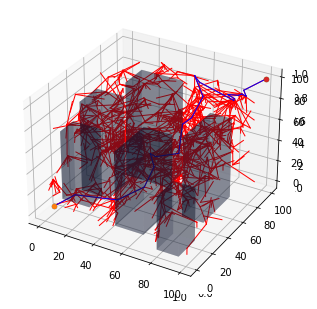

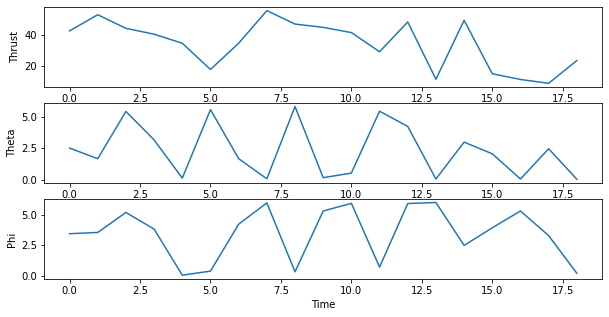

In [66]:
start = (0,10,0)
goal = (100,100,100)

# 3D boxes   lx, ly, lz, hx, hy, hz
obstacles = [
    [0, 20, 0, 20, 35, 65],
    [5, 35, 0, 25, 55, 85],
    [45, 10, 0, 65, 45, 70],
    [20, 65, 0, 50, 85, 90],
    [75, 40, 0, 90, 75, 75],
    [80, 0, 0, 95, 20, 50]
]

env = Env(obstacles, 0, 100, 0, 100, 0, 100)

hn_RRT = holonomic_RRT(start, goal, env)
hn_RRT.show_env()
hn_RRT.test_env(goal_check_iterations = 20, radius = 30)